# Overview



# Imports

In [190]:
import functools
import itertools
import multiprocessing
import os.path as op
import queue

import apache_beam as beam
import matplotlib.pyplot as plt
import pandas as pd
from apache_beam.runners.direct.direct_runner import BundleBasedDirectRunner
from apache_beam.runners.interactive.cache_manager import (
    FileBasedCacheManager, ReadCache, WriteCache)
from apache_beam.runners.interactive.interactive_runner import \
    InteractiveRunner
from apache_beam.runners.portability.fn_api_runner import FnApiRunner

try:
    from pathlib import Path
except ImportError:
    from pathlib2 import Path

In [38]:
%matplotlib inline

# Parameters

In [27]:
NOTEBOOK_NAME = "interactive-beam-demo"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)

NOTEBOOK_NAME

interactive-beam-demo

In [28]:
project_id = "strokach-playground"

In [9]:
runner = beam.runners.dataflow.DataflowRunner(
    # interactive=True,
    # timeout="30min"
)

In [10]:
options = beam.pipeline.PipelineOptions(
    project=project_id,
    job_name=NOTEBOOK_NAME,
    temp_location="gs://strokach/dataflow_temp",
    staging_location="gs://strokach/dataflow_staging",
    sdk_location=op.expanduser(
        "~/workspace/beam/sdks/python/dist/apache-beam-2.14.0.dev0.tar.gz"
    ),
)
options.display_data()

{job_name: interactive-beam-demo,
 project: strokach-playground,
 sdk_location: /usr/local/google/home/strokach/workspace/beam/sdks/python/dist/apache-beam-2.14.0.dev0.tar.gz,
 staging_location: gs://strokach/dataflow_staging,
 temp_location: gs://strokach/dataflow_temp}

In [11]:
cache_manager = FileBasedCacheManager(
    cache_dir="gs://strokach/tmp"
)
# atexit.register(cache_manager.cleanup) <- 

# Setup

In [12]:
# runner.__enter__()
# runner.start_session() (?)

# Workflow

### Running a pipeline

In [30]:
with beam.Pipeline(runner=runner, options=options) as p:  # display=...
    _ = (
        #
        p
        | "Read" >> beam.io.ReadFromText("gs://strokach/inputs/winterstale")
        | "Write" >> WriteCache(cache_manager, "temp")
    )

#### Notes

- `p.run()` should start the pipeline in the background, even in interactive mode. This makes sense for streaming, or when we want to start reading results as they appear.

- There should be an option to display results while the pipeline is running. However, we should display results when we call `result.wait_until_finish()`, not when we call `p.run()`.

- `result.wait_until_finish()` should not wait for the VM to shut down.

- `WriteCache` should take an extra argument `format`, which allows the use to specify the format that will be used for writing the cache file. It should also be possible to pass additional arguments such as `schema=...`, etc.

### Reading from cache

In [16]:
# The argument should be just "temp", and it should not return "version"
data, _ = cache_manager.read("full", "temp")  

In [35]:
df = pd.DataFrame(data[0], columns=["string"])

df["string_clean"] = df["string"].str.strip()
df["string_length"] = df["string_clean"].str.len()

Text(0,0.5,'Number of strings')

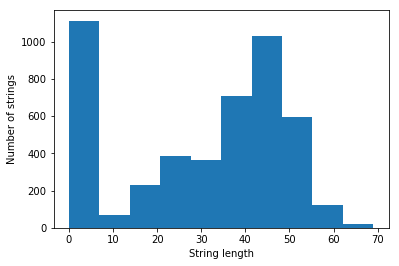

In [39]:
fg, ax = plt.subplots()

_ = ax.hist(df["string_length"])
ax.set_xlabel("String length")
ax.set_ylabel("Number of strings")

#### Notes

- When we read from a `CacheManager`, we should not have to specify "full" or "sample". If the user so desires, they can provide that information in the name that they give to their cache object.

- `CacheManager.read(...)` should not return the cache version by default. It should be assumeed that we are always reading the latest cache object.

- `CacheManager.read(...)` should have a `limit=...` argument.

### Querying cache using Beam SQL, BigQuery, etc.

Until we have a Python frontend for Beam SQL, 

#### Notes

### Processing cached objects using DirectRunner

For simple types of queries that are likely to be limited by I/O, it may be helpful to explore the data using `DirectRunner`. Furthermore, we might want to store the output directly in memory instead of saving it to a file. Both the `BundleBasedDirectRunner` and the `FnApiRunner` run workers inside Python threads, so the results can simply be passed into a `queue.Queue()`. If `DirectRunner` ever switches to using `multiprocessing` ([BEAM-1442](https://issues.apache.org/jira/browse/BEAM-1442)), a more sophisticated way of transfering data between processes may be required. For example, PyTorch creates memory-mapped files, and passes filehandes to those files between processes.

In [182]:
def add_to_queue(element, queue):
    queue.put(element)

In [183]:
q = queue.Queue()

with beam.Pipeline(runner=BundleBasedDirectRunner()) as p:
    _ = (
        #
        p
        | "Read" >> ReadCache(cache_manager, "temp")
        | "Remove whitespace" >> beam.Map(lambda element: element.strip("\n\t|"))
        | "Remove empty lines" >> beam.FlatMap(lambda element: [element] if element else [])
        | "Write" >> beam.Map(lambda element: add_to_queue(element, queue=q))
    )

In [184]:
data = list(q.queue)

Text(0,0.5,'Number of strings')

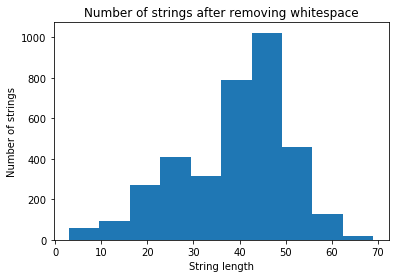

In [188]:
fg, ax = plt.subplots()

_ = ax.hist([len(s) for s in data])
ax.set_title("Number of strings after removing whitespace")
ax.set_xlabel("String length")
ax.set_ylabel("Number of strings")

#### Notes

- It may be useful to have a well-defined class for outputing results to an object in the main process. That way, if the implementation of `DirectRunner` changes, this way of accessing results could remain backwards-compatible.

In [ ]:
reader = beam.io.textio.ReadFromText("gs://strokach/inputs/winterstale")
range_tracker = reader._source.get_range_tracker(None, None)
data = list(reader._source.read(range_tracker))

# Cleanup

In [ ]:
cache_manager.cleanup()

In [ ]:
# runner.__exit__()
# runner.end_session() (?)